# **Import Libraries**

In [23]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
import missingno as msno

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, GlobalAvgPool2D, MaxPool2D, BatchNormalization, Flatten, LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
print("Done")

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip
Done


In [25]:
PATH = "../input/facial-keypoints-detection"

TEST_PATH = os.path.join(PATH, "test.zip")
TRAIN_PATH = os.path.join(PATH, "training.zip")
TABLE_PATH = os.path.join(PATH, "IdLookupTable.csv")
SUBMISSION_PATH = os.path.join(PATH, "SampleSubmission.csv")

ACTIVATION = "gelu"

# **Function** 🧮 
to see the characteristics of the data such as missing values (NaN), all of features and number, records and columns

In [26]:
def data_description(df):
    print("Data description")
    print(f"Total number of records {df.shape[0]}")
    print(f'number of features {df.shape[1]}\n\n')
    columns = df.columns
    data_type = []
    
    # Get the datatype of features
    for col in df.columns:
        data_type.append(df[col].dtype)
        
    n_uni = df.nunique()
    # Number of NaN values
    n_miss = df.isna().sum()
    
    names = list(zip(columns, data_type, n_uni, n_miss))
    variable_desc = pd.DataFrame(names, columns=["Name","Type","Unique levels","Missing"])
    print(variable_desc)

## **Show a heatmap with correlation of all the values of the dataset**



In [27]:
def show_corr(df, title):
    corr = df.corr()
    plt.figure(figsize = (20, 15))
    plt.title(title)
    sns.heatmap(corr, annot=True, linewidths=.3)

## **Show all the values and nan values in one column**

In [28]:
def nan_values_data (df, column):
    nan_values = df[column].isna().sum()
    total_values = df[column].sum()
    print(f"{nan_values} : {total_values}")

# Data processing

In [29]:
test_data = pd.read_csv(TEST_PATH, compression='zip')
train_data = pd.read_csv(TRAIN_PATH, compression='zip')
table_data = pd.read_csv(TABLE_PATH)
submission_data = pd.read_csv(SUBMISSION_PATH)

# Display a portion of the data from all dataframes

In [30]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


## **Show important information of the dataframe**

In [31]:
data_description(test_data)

Data description
Total number of records 1783
number of features 2


      Name    Type  Unique levels  Missing
0  ImageId   int64           1783        0
1    Image  object           1752        0


In [32]:
train_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [33]:
data_description(train_data)

Data description
Total number of records 7049
number of features 31


                         Name     Type  Unique levels  Missing
0           left_eye_center_x  float64           7021       10
1           left_eye_center_y  float64           7020       10
2          right_eye_center_x  float64           7027       13
3          right_eye_center_y  float64           7015       13
4     left_eye_inner_corner_x  float64           2268     4778
5     left_eye_inner_corner_y  float64           2256     4778
6     left_eye_outer_corner_x  float64           2256     4782
7     left_eye_outer_corner_y  float64           2251     4782
8    right_eye_inner_corner_x  float64           2252     4781
9    right_eye_inner_corner_y  float64           2258     4781
10   right_eye_outer_corner_x  float64           2259     4781
11   right_eye_outer_corner_y  float64           2259     4781
12   left_eyebrow_inner_end_x  float64           2266     4779
13   left_eyebrow_inner_end_y  float64          

In [34]:
table_data.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [35]:
data_description(table_data)

Data description
Total number of records 27124
number of features 4


          Name     Type  Unique levels  Missing
0        RowId    int64          27124        0
1      ImageId    int64           1783        0
2  FeatureName   object             30        0
3     Location  float64              0    27124


<AxesSubplot:>

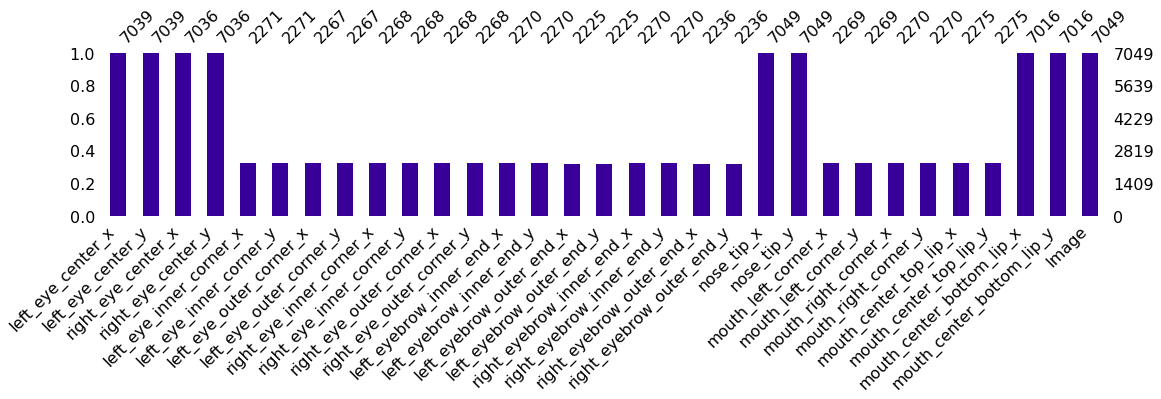

In [36]:
msno.bar(train_data,figsize=(18,3), color='#390099')


As we said earlier a lot of features have more than 60% of missing of missing values. 

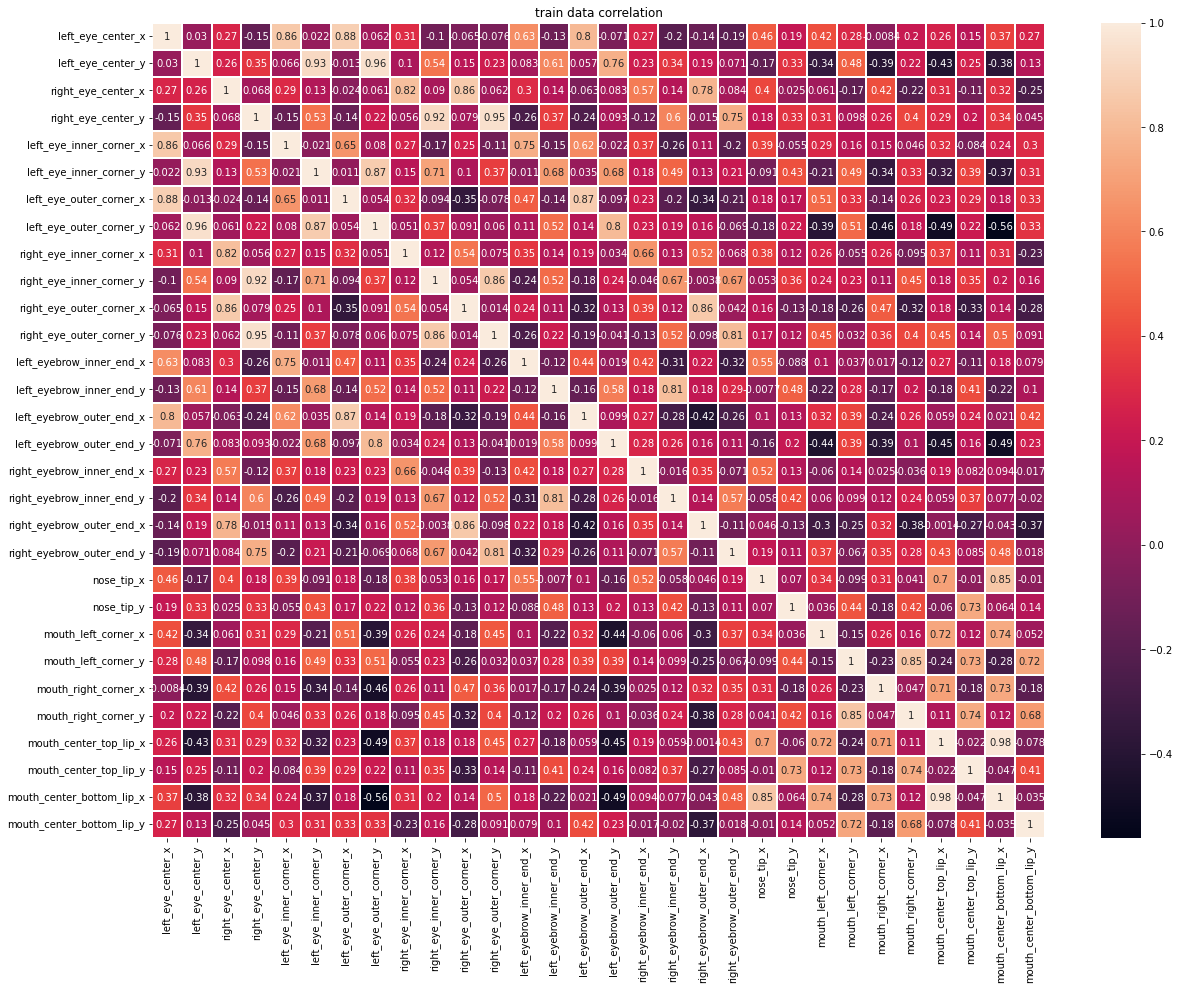

In [37]:
show_corr(train_data, "train data correlation")

## **Fill the Nan values with the metod ffill,**
Fill metod replace the Null values with the previous row (or previous column, if the axis parameter is set to 'columns').



In [38]:
train_data = train_data.fillna(method = "ffill")

# **Create a image array with the values in train_data**

In [39]:
img_array = np.array([train_data['Image'][i].split(' ') 
                      for i in range(len(train_data))],dtype='float')
r_img =np.array([img.reshape(96,96,1) for img in img_array])

# **Displays a few images of the dataset**

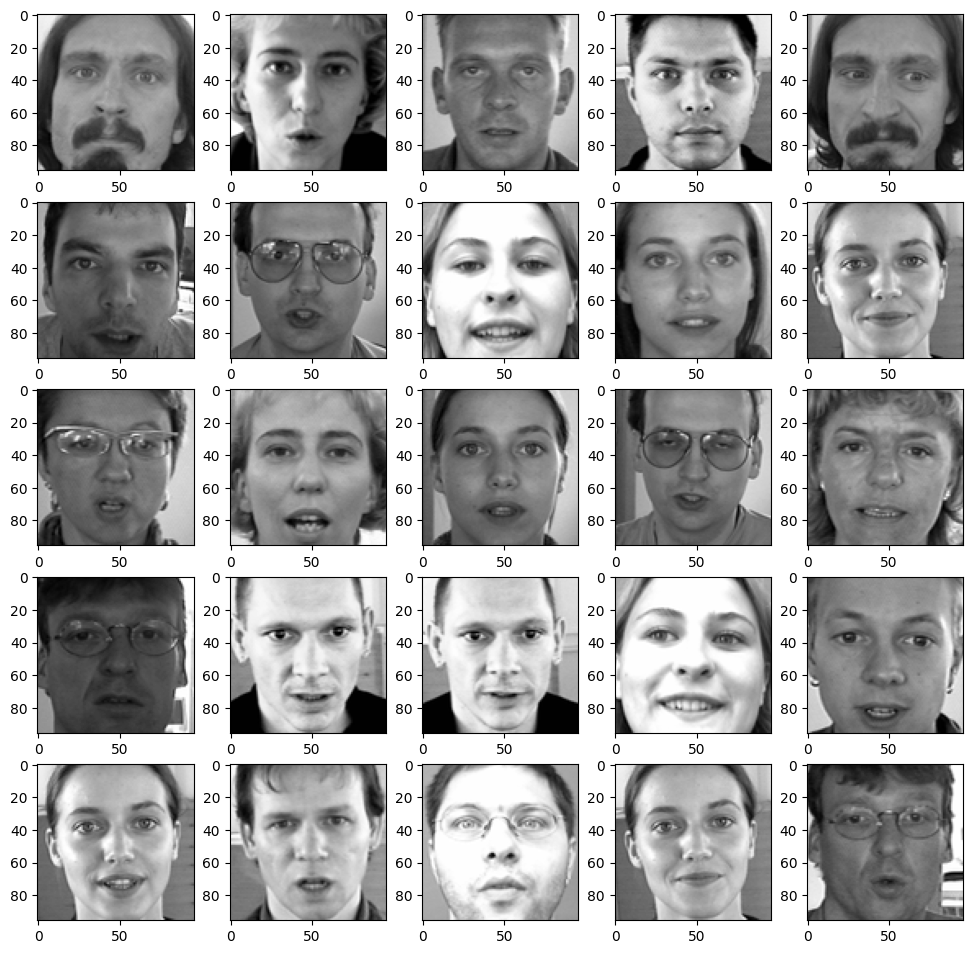

In [48]:
fig, ax = plt.subplots(5,5,figsize = (12,12), dpi = 100)
axes = ax.ravel()

for idx,ax  in enumerate(axes):
    ax.imshow(r_img[idx],cmap='gray')
fig.show()

# **Show the images with the correspondent "dots"**

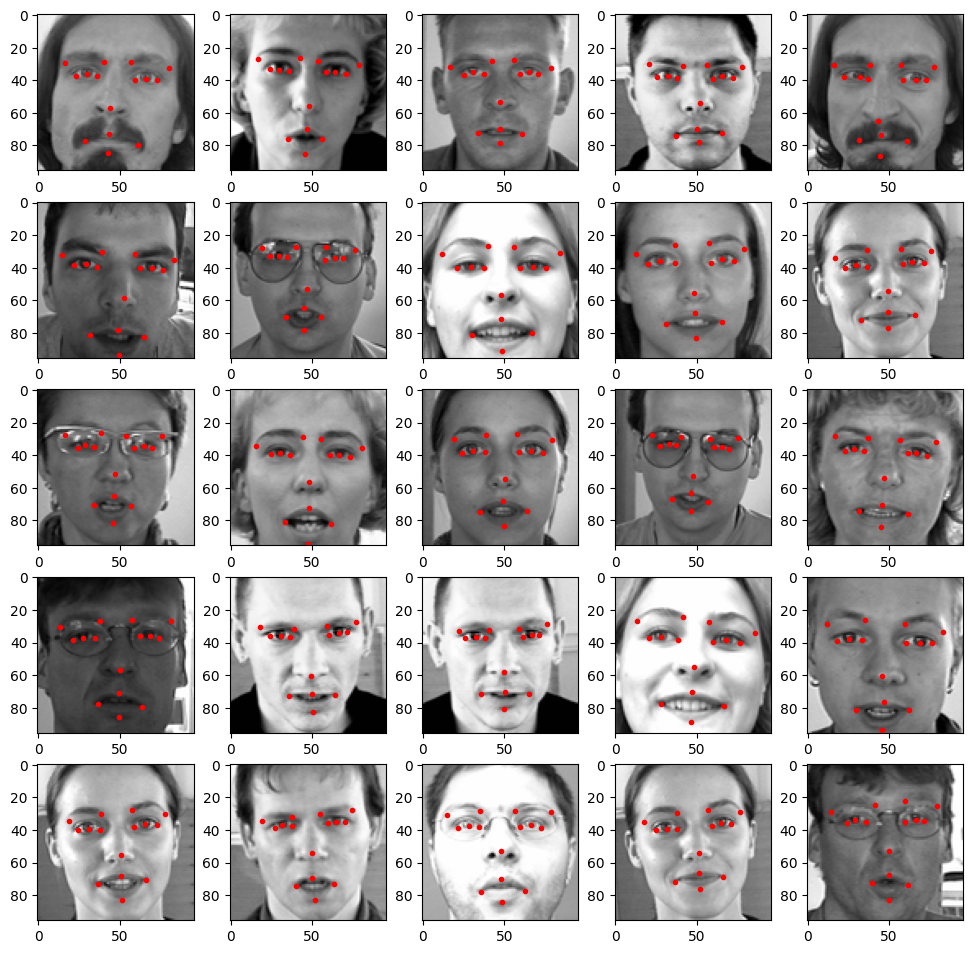

In [51]:
fig, ax = plt.subplots(5,5,figsize = (12,12), dpi = 100)
axes = ax.ravel()

position_data = train_data.drop(["Image"], axis = 1)

for idx,ax  in enumerate(axes):
    ax.imshow(r_img[idx],cmap='gray')
    photo_visualize_pnts = position_data.iloc[idx].values
    ax.scatter(photo_visualize_pnts[0::2], photo_visualize_pnts[1::2], c='Red', marker='.')
fig.show()

# **Put the images in array using array_to_img**

In [53]:
image=[array_to_img(img_array[i,:].reshape(96,96,1)) for i in range(len(img_array))]
image[:5]

[<PIL.Image.Image image mode=L size=96x96>,
 <PIL.Image.Image image mode=L size=96x96>,
 <PIL.Image.Image image mode=L size=96x96>,
 <PIL.Image.Image image mode=L size=96x96>,
 <PIL.Image.Image image mode=L size=96x96>]

if not os.path.exists('./Images/'):
    os.makedirs('./Images/')

for idx,x in enumerate(image):
    x.save(f'./image_{idx}.jpg', 'JPEG')

# **Show raw images**

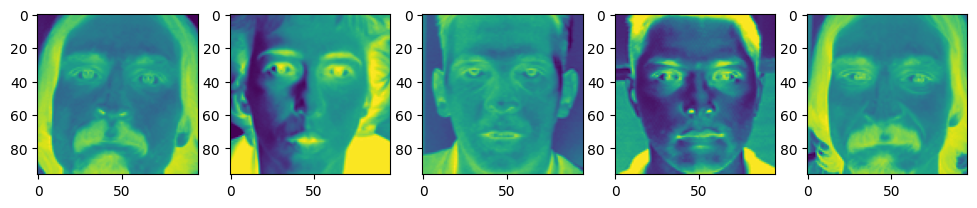

In [57]:
fig, ax = plt.subplots(1,5,figsize = (12,12), dpi = 100)
axes = ax.ravel()
for idx,ax  in enumerate(axes):
    mask=np.full((96,96,1),255)
    ax.imshow((mask-r_img[idx]))
fig.show()

# **Data Augmentation using ImageDataGenerator**


In [58]:
target = train_data.drop(['Image'],axis=1).columns

datagen = ImageDataGenerator (
    rotation_range = 20, # maximum level of rotation
    shear_range = 30,# 
    brightness_range=[0, 5],# The range of brightness that the can increase
)

train_images=datagen.flow_from_dataframe(
    dataframe=train_data, 
    x_col='Image', y_col=target,  
    target_size=(96, 96), color_mode='grayscale',  
    classes=None, class_mode='raw', 
    validate_filenames=False,
    )

Found 7049 non-validated image filenames.


# **Transform into a NumpyArray**

In [59]:
position_data = train_data.drop(["Image"], axis = 1)
position_data = np.array(position_data, dtype = float) # Y or target
r_img = np.array(r_img, dtype = float) # X

# **train_test_split, with a 20%(0.2) of test data and 80% to train data**

In [60]:
X_train,X_val, Y_train, Y_val = train_test_split(r_img, position_data, test_size=0.2 ,shuffle=True)

# Train 🧠
Create the model with Conv2D and MaxPool2D

In [61]:
model = Sequential ([
    tf.keras.layers.Conv2D(64, (3,3),  input_shape = (96, 96, 1), activation = ACTIVATION),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation = ACTIVATION, kernel_regularizer='l1_l2'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(150, (3,3), activation = ACTIVATION, kernel_regularizer='l1_l2'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(200, (3,3), activation = ACTIVATION, kernel_regularizer='l1_l2'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1250, activation = ACTIVATION, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(525, activation = ACTIVATION, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation = ACTIVATION, kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(30, activation = "relu"),
])

2023-02-04 00:08:02.692800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 00:08:02.788152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 00:08:02.789004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 00:08:02.790920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# **Complile the model**

In [62]:
model.compile(optimizer = "adam",
                loss = 'mae',
                metrics = [tf.keras.metrics.RootMeanSquaredError()])

# **Create EarlyStopping callback,**
with a patience of 30, This callback, for the model when the success values begin to fall, this callback, for the model when the success values begin to fall

In [ ]:
es_callback = EarlyStopping(monitor = "root_mean_squared_error", patience=30, restore_best_weights = True)

# Fit the model

In [ ]:
history=model.fit(
    X_train, Y_train,
    validation_data = (X_val, Y_val),
    callbacks = [es_callback],
    epochs = 250,
    )

# Show model performance info

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot()

In [ ]:
# Flatten the Test Images
test_pred = np.array([test_data['Image'][i].split(' ') for i in range(len(test_data))],dtype='float')
# viz_test

# Reconstruct the Test Images
test_pred=np.array([img.reshape(96,96,1) for img in test_pred])
test_pred[:2]

In [ ]:
pred = model.predict(test_pred)

# Submission 📩

In [ ]:
feature_names = list(table_data['FeatureName'])
image_ids = list(table_data['ImageId']-1)
row_ids = list(table_data['RowId'])

feature_list = [feature_names.index(feature) for feature in feature_names]
    
predictions = [pred[x][y] for x,y in zip(image_ids, feature_list)]
predictions[:5]

In [ ]:
submission=pd.DataFrame({'RowId': row_ids,
                         'Location': predictions,
                        })
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)
print("Completed")